*Author: Pooya Bagheri*

**NotFinalizedYet**

## 1 Creating objects for Incremental Loading
I have written a class called [*DataGenerator*](IncrementalLoading.py) for incremental loading of data. The object from this class loads data for a chunk (consisting of few days) at once to avoid memory problems. 

We use this object to extend our training set to the first 22 days available in the dataset:

In [1]:
from IncrementalLoading import DataGenerator
from LoadingDataClass import MLinputData

MyDataGen=DataGenerator(1,22,7) #Data generator to incrementally load data for the first 22 days (each chunk includes 7 days)

#Load and scale validation data:
validation=MLinputData(23,25) # Loading validation data (23rd to 25th day)
#Create a tuple including scaled validation data suitable for Keras:
validation_data=(MyDataGen.scaler_x.transform(validation.x),MyDataGen.scaler_y.transform(validation.y))

#Load and scale test data:
test=MLinputData(26,30) # Loading Test sets (last 5 of 30 days)
x_test=MyDataGen.scaler_x.transform(test.x)

## 2. Training ANN by incremental loading
We start the training on on a ANN network with similar structure to the last example in the [previous step](Step3-MLmodels-NeuralNetworks.ipynb):

In [2]:
import warnings
warnings.filterwarnings("ignore") #in order to avoid unnecessary warnings when loading Keras modules

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

##Defining structure of models
DataWidth=MyDataGen.xData.shape[1]
models=[]
#First one is similar to last example in previous step
model=Sequential()
model.add(Dense(DataWidth, input_dim=DataWidth,kernel_initializer='uniform',activation='relu')) #1st hidden layer
model.add(Dense(DataWidth, input_dim=DataWidth,kernel_initializer='uniform',activation='relu')) #2nd hidden layer
model.add(Dense(1,input_dim=DataWidth,kernel_initializer='uniform',activation='linear')) #output layer
models.append(model)
#Second one is with two extra hidden layers:
model=Sequential()
model.add(Dense(DataWidth, input_dim=DataWidth,kernel_initializer='uniform',activation='relu')) #1st hidden layer
model.add(Dense(DataWidth, input_dim=DataWidth,kernel_initializer='uniform',activation='relu')) #2nd hidden layer
model.add(Dense(DataWidth, input_dim=DataWidth,kernel_initializer='uniform',activation='relu')) #3rd hidden layer
model.add(Dense(int(DataWidth/2), input_dim=DataWidth,kernel_initializer='uniform',activation='relu')) #4th hidden layer
model.add(Dense(1,input_dim=int(DataWidth/2),kernel_initializer='uniform',activation='linear')) #output layer
models.append(model)
#Third one is with hidden layers that start wide and gradually gets narrow:
model=Sequential()
model.add(Dense(2*DataWidth, input_dim=DataWidth,kernel_initializer='uniform',activation='relu')) #1st hidden layer
model.add(Dense(DataWidth, input_dim=2*DataWidth,kernel_initializer='uniform',activation='relu')) #2nd hidden layer
model.add(Dense(int(DataWidth/2), input_dim=DataWidth,kernel_initializer='uniform',activation='relu')) #3rd hidden layer
model.add(Dense(int(DataWidth/4), input_dim=int(DataWidth/2),kernel_initializer='uniform',activation='relu')) #4th hidden layer
model.add(Dense(1,input_dim=int(DataWidth/4),kernel_initializer='uniform',activation='linear')) #output layer
models.append(model)

##Compile the models:
for model in models:
    model.compile(optimizer='Adam' ,loss='mse',metrics=['mse'])

Using TensorFlow backend.


In [3]:
BatchSizeList=[1024,32,4,1] #batch sizes to be tried

LearnHists=dict()
for j,BatchSize in enumerate(BatchSizeList):
    for i,model in enumerate(models):
        print('Training for model %d, batch_size=%d:' % (i+1,BatchSize))
        checkpoint=ModelCheckpoint("ANNweights%d-%d-best.hdf5" % (i+1,j), monitor='val_mean_squared_error', verbose=0, save_best_only=True, mode='min')
        DataGenIterator=MyDataGen.__iter__(BatchSize) #Creating iterator object for incremental data generation used by Keras training function
        model.reset_states()
        #Let's call Keras training function suitable for incremental loading:
        LearnHists[(i+1,j)]=model.fit_generator(generator=DataGenIterator, steps_per_epoch=DataGenIterator.StepsPerEpoch(), epochs=30, verbose=1, callbacks=[checkpoint], validation_data=validation_data, shuffle=True)

Training for model 1, batch_size=1024:
Epoch 1/30
30/30 [==============================] - 33s 1s/step - loss: 0.2491 - mean_squared_error: 0.2491 - val_loss: 0.0803 - val_mean_squared_error: 0.0803
Epoch 2/30
30/30 [==============================] - 56s 2s/step - loss: 0.0512 - mean_squared_error: 0.0512 - val_loss: 0.0496 - val_mean_squared_error: 0.0496
Epoch 3/30
30/30 [==============================] - 56s 2s/step - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.0096 - val_mean_squared_error: 0.0096
Epoch 4/30
30/30 [==============================] - 55s 2s/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 5/30
30/30 [==============================] - 55s 2s/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 6/30
30/30 [==============================] - 40s 1s/step - loss: 0.0055 - mean_squared_error: 0.0055 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
E

30/30 [==============================] - 56s 2s/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0160 - val_mean_squared_error: 0.0160
Epoch 22/30
30/30 [==============================] - 41s 1s/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0107 - val_mean_squared_error: 0.0107
Epoch 23/30
30/30 [==============================] - 56s 2s/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0140 - val_mean_squared_error: 0.0140
Epoch 24/30
30/30 [==============================] - 57s 2s/step - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 25/30
30/30 [==============================] - 56s 2s/step - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.0167 - val_mean_squared_error: 0.0167
Epoch 26/30
30/30 [==============================] - 59s 2s/step - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0334 - val_mean_squared_error: 0.0334
Epoch 27/30
30/30 [===========================

990/990 [==============================] - 57s 58ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0423 - val_mean_squared_error: 0.0423
Epoch 12/30
990/990 [==============================] - 58s 58ms/step - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 0.0950 - val_mean_squared_error: 0.0950
Epoch 13/30
990/990 [==============================] - 59s 60ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 14/30
990/990 [==============================] - 58s 59ms/step - loss: 0.0259 - mean_squared_error: 0.0259 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 15/30
990/990 [==============================] - 58s 59ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0112 - val_mean_squared_error: 0.0112
Epoch 16/30
990/990 [==============================] - 59s 59ms/step - loss: 0.0397 - mean_squared_error: 0.0397 - val_loss: 0.0349 - val_mean_squared_error: 0.0349
Epoch 17/30
990/990 [=

Training for model 3, batch_size=32:
Epoch 1/30
990/990 [==============================] - 45s 45ms/step - loss: 0.4404 - mean_squared_error: 0.4404 - val_loss: 0.1898 - val_mean_squared_error: 0.1898
Epoch 2/30
990/990 [==============================] - 61s 61ms/step - loss: 0.1252 - mean_squared_error: 0.1252 - val_loss: 0.3300 - val_mean_squared_error: 0.3300
Epoch 3/30
990/990 [==============================] - 61s 61ms/step - loss: 0.1049 - mean_squared_error: 0.1049 - val_loss: 0.0881 - val_mean_squared_error: 0.0881
Epoch 4/30
990/990 [==============================] - 60s 61ms/step - loss: 0.0677 - mean_squared_error: 0.0677 - val_loss: 0.1028 - val_mean_squared_error: 0.1028
Epoch 5/30
990/990 [==============================] - 63s 63ms/step - loss: 0.0602 - mean_squared_error: 0.0602 - val_loss: 0.0377 - val_mean_squared_error: 0.0377
Epoch 6/30
990/990 [==============================] - 60s 60ms/step - loss: 0.1082 - mean_squared_error: 0.1082 - val_loss: 0.3618 - val_mean_s

1131/1131 [==============================] - 2s 2ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.0522 - val_mean_squared_error: 0.0522
Epoch 21/30
1131/1131 [==============================] - 2s 2ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.2140 - val_mean_squared_error: 0.2140
Epoch 22/30
1131/1131 [==============================] - 27s 24ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.1370 - val_mean_squared_error: 0.1370
Epoch 23/30
1131/1131 [==============================] - 2s 2ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.1088 - val_mean_squared_error: 0.1088
Epoch 24/30
1131/1131 [==============================] - 18s 16ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - val_loss: 0.0592 - val_mean_squared_error: 0.0592
Epoch 25/30
1131/1131 [==============================] - 2s 2ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0606 - val_mean_squared_error: 0.0606
Epoch 26/30
1131/1

Epoch 9/30
1131/1131 [==============================] - 5s 4ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0209 - val_mean_squared_error: 0.0209
Epoch 10/30
1131/1131 [==============================] - 20s 18ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0621 - val_mean_squared_error: 0.0621
Epoch 11/30
1131/1131 [==============================] - 5s 4ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - val_loss: 0.0369 - val_mean_squared_error: 0.0369
Epoch 12/30
1131/1131 [==============================] - 20s 18ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.0570 - val_mean_squared_error: 0.0570
Epoch 13/30
1131/1131 [==============================] - 4s 4ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0433 - val_mean_squared_error: 0.0433
Epoch 14/30
1131/1131 [==============================] - 5s 4ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - val_loss: 0.0865 - val_mean_squared_error: 0.0865
Epoch 1

31680/31680 [==============================] - 109s 3ms/step - loss: 9.0459e-04 - mean_squared_error: 9.0459e-04 - val_loss: 0.1206 - val_mean_squared_error: 0.1206
Epoch 28/30
31680/31680 [==============================] - 109s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0548 - val_mean_squared_error: 0.0548
Epoch 29/30
31680/31680 [==============================] - 109s 3ms/step - loss: 8.9942e-04 - mean_squared_error: 8.9942e-04 - val_loss: 0.0455 - val_mean_squared_error: 0.0455
Epoch 30/30
31680/31680 [==============================] - 117s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Training for model 2, batch_size=1:
Epoch 1/30
4525/4525 [==============================] - 39s 9ms/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0597 - val_mean_squared_error: 0.0597
Epoch 2/30
4525/4525 [==============================] - 15s 3ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_

31680/31680 [==============================] - 162s 5ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - val_loss: 2.3277 - val_mean_squared_error: 2.3277
Epoch 16/30
31680/31680 [==============================] - 161s 5ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - val_loss: 2.3772 - val_mean_squared_error: 2.3772
Epoch 17/30
31680/31680 [==============================] - 161s 5ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 2.4246 - val_mean_squared_error: 2.4246
Epoch 18/30
31680/31680 [==============================] - 163s 5ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 2.4719 - val_mean_squared_error: 2.4719
Epoch 19/30
31680/31680 [==============================] - 160s 5ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 2.5164 - val_mean_squared_error: 2.5164
Epoch 20/30
31680/31680 [==============================] - 169s 5ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 2.5599 - val_mean_squared_error: 2.559

In [6]:
from sklearn.metrics import mean_absolute_error 
print('List of prediction errors:')
for i,model in enumerate(models):
    print('-Model %d' % (i+1))
    for j,BatchSize in enumerate(BatchSizeList):
        model.load_weights("ANNweights%d-%d-best.hdf5" % (i+1,j))
        y_predicted=MyDataGen.scaler_y.inverse_transform(model.predict(x_test))
        PredictionError=mean_absolute_error(y_predicted,test.y)/test.y.mean()*100
        print('--batch_size=%d : %.2f%%' % (BatchSize,PredictionError))        

List of prediction errors:
-Model 1
--batch_size=1024 : 1.80%
--batch_size=32 : 3.46%
--batch_size=4 : 6.53%
--batch_size=1 : 3.44%
-Model 2
--batch_size=1024 : 2.75%
--batch_size=32 : 4.01%
--batch_size=4 : 4.01%
--batch_size=1 : 4.68%
-Model 3
--batch_size=1024 : 1.71%
--batch_size=32 : 2.31%
--batch_size=4 : 3.67%
--batch_size=1 : 5.33%


Learning curve for Model 1 and batch_size=1024 :


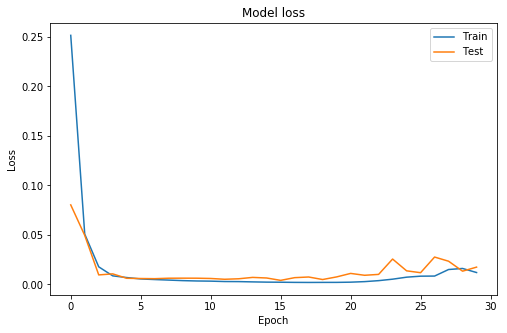

Learning curve for Model 1 and batch_size=32 :


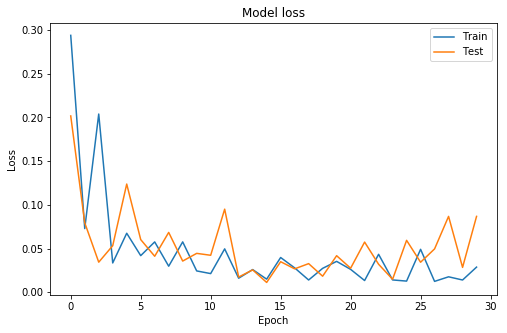

Learning curve for Model 1 and batch_size=4 :


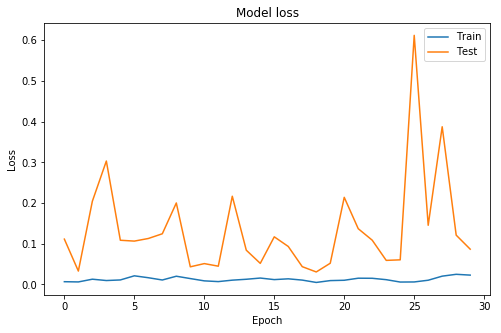

Learning curve for Model 1 and batch_size=1 :


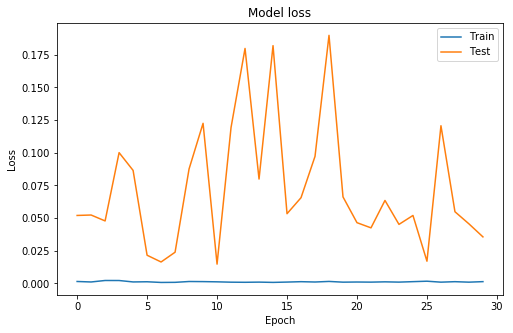

Learning curve for Model 2 and batch_size=1024 :


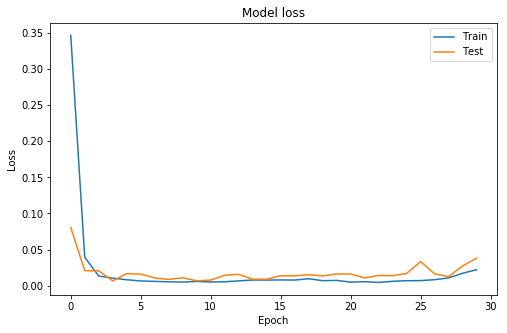

Learning curve for Model 2 and batch_size=32 :


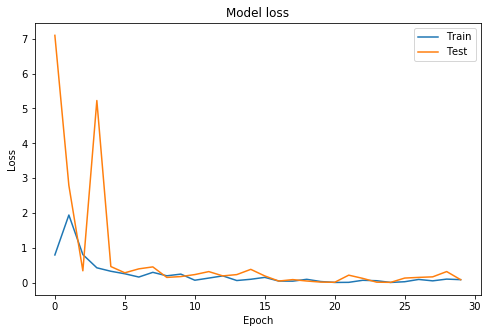

Learning curve for Model 2 and batch_size=4 :


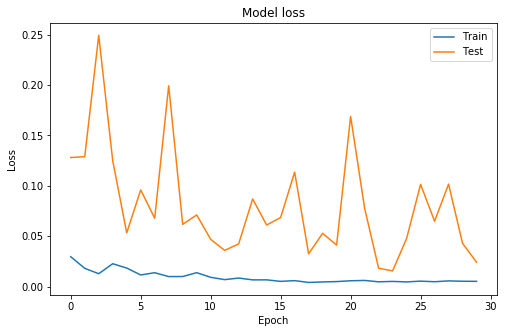

Learning curve for Model 2 and batch_size=1 :


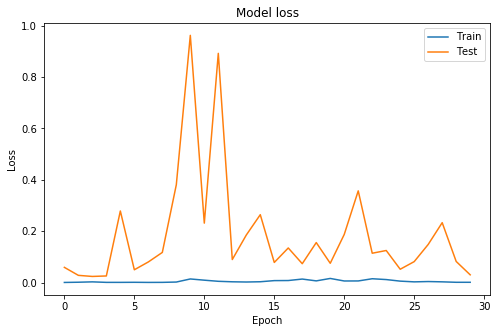

Learning curve for Model 3 and batch_size=1024 :


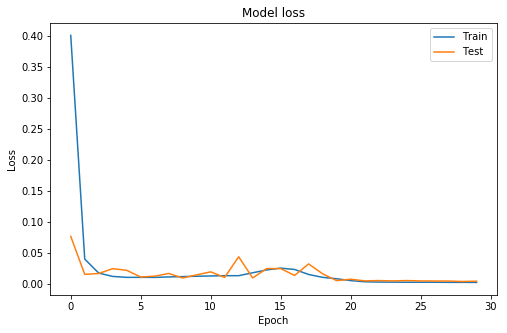

Learning curve for Model 3 and batch_size=32 :


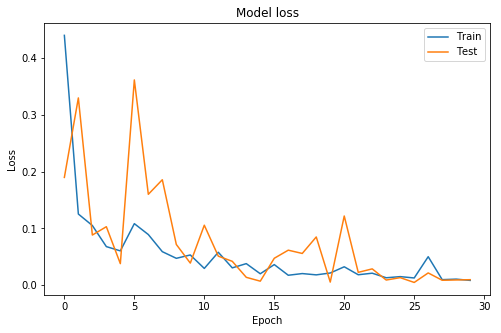

Learning curve for Model 3 and batch_size=4 :


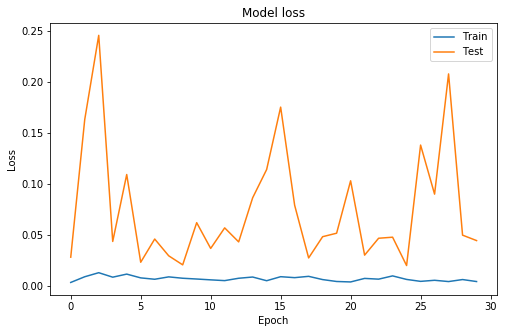

Learning curve for Model 3 and batch_size=1 :


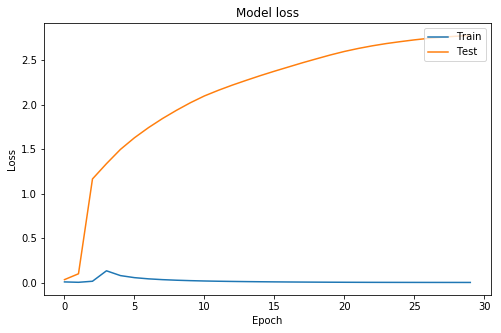

In [11]:
from MyPlotTools import Plot
Plt=Plot(FromDay=26,ToDay=30,plotHeight=5,plotWidth=8)
for i,model in enumerate(models):
    for j,BatchSize in enumerate(BatchSizeList):
        print('Learning curve for Model %d and batch_size=%d :' % (i+1,BatchSize))  
        Plt.LearningCurve(LearnHists[(i+1,j)])
